In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

transform_val = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./', train=True, download=True, transform = transform_train)
val_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform = transform_val)
val_dataset

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
def img_convert(tensor):
    im = tensor.cpu().clone().detach().numpy() 
    im = im.transpose(1,2,0) 
    #denormalization
    im = im * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    im = im.clip(0,1)
    
    return im

In [5]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size = 100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = 100, shuffle=False) #no training in this dataset, so no need to shuffle

In [6]:
label_classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

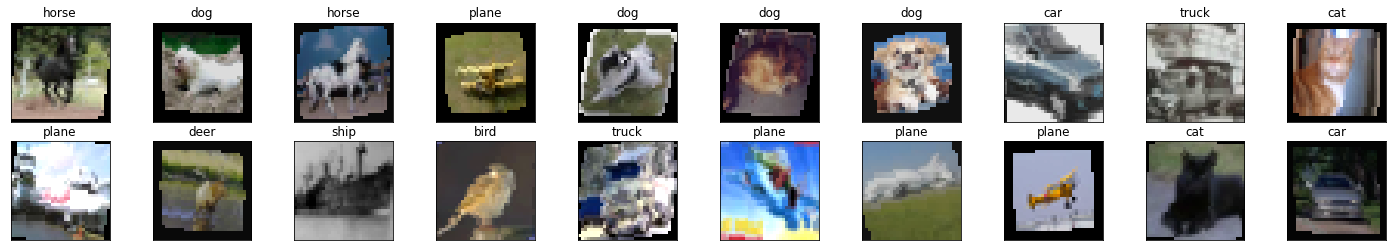

In [7]:
im_iter = iter(training_loader)
imgs, labels = im_iter.next()
fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(imgs[i])))
    ax.set_title(label_classes[labels[i].item()])

In [8]:
class LeNetModel (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3 ,16,3,1, padding=1) # decrease kernel size to avoid overfitting
        self.conv2 = nn.Conv2d(16,32,3,1, padding=1)
        self.conv3 = nn.Conv2d(32,64,3,1, padding=1)
        self.full_conn1 = nn.Linear(64*4*4, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.full_conn2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,2) # cut image size by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2,2)
        x = x.view(-1, 4*4*64) # start with 32 x 32 iamge, then 3 max pooling layer, each reduce by half, end up to be 4x4
        x = F.relu(self.full_conn1(x))
        x = self.dropout1(x)
        x = self.full_conn2(x)
        return x

In [9]:
model = LeNetModel().to(device)
model

LeNetModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (full_conn1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (full_conn2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #smaller learning rate will make the plot of loss function more smooth, as it will avoid overshooting

In [11]:
epochs = 10
losses = []
accuracies = []

val_losses = []
val_accuracies = []

In [12]:
for i in range(epochs):
    print("epoch: ", i+1)
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    val_epoch_loss = 0.0
    val_epoch_acc = 0.0
    
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        loss = loss_func(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, max_idx = torch.max(outputs, 1) # 1 here indicates dim = 1, which is calculating max in horizontal direction, dim = 0 is vertical, dim = 2 is in depth direction.
        epoch_loss += loss.item()
        epoch_acc += torch.sum(max_idx == labels.data).item() # since batch size is 100, no need to divide by size then multiply by 100 to get % accuracy.

    
    tot_loss = epoch_loss/len(training_loader)
    tot_acc = epoch_acc/len(training_loader)
    losses.append(tot_loss)
    accuracies.append(tot_acc)
    print("training loss: {:.4f}, accuracy: {:.4f}".format(tot_loss, tot_acc))
    
    #validation phase
    
    with torch.no_grad(): #to save memory, set all grad flags to False
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model.forward(val_images)
            val_loss = loss_func(val_outputs, val_labels)

            _, max_idx = torch.max(val_outputs, 1)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += torch.sum(max_idx == val_labels.data)
     
    val_tot_loss = val_epoch_loss/len(val_loader)
    val_tot_acc = val_epoch_acc/len(val_loader)
    val_losses.append(val_tot_loss)
    val_accuracies.append(val_tot_acc)
    print("val loss: {:.4f}, val accuracy: {:.4f}".format(val_tot_loss, val_tot_acc))

epoch:  1
training loss: 1.7091, accuracy: 37.4960
val loss: 1.3905, val accuracy: 49.2000
epoch:  2
training loss: 1.3996, accuracy: 49.8820
val loss: 1.2493, val accuracy: 55.5600
epoch:  3
training loss: 1.2741, accuracy: 54.6980
val loss: 1.1168, val accuracy: 60.7400
epoch:  4
training loss: 1.1887, accuracy: 57.9480
val loss: 1.0425, val accuracy: 62.6000
epoch:  5
training loss: 1.1322, accuracy: 59.8720
val loss: 0.9911, val accuracy: 64.6400
epoch:  6
training loss: 1.0789, accuracy: 62.0880
val loss: 0.9749, val accuracy: 65.2100
epoch:  7
training loss: 1.0371, accuracy: 63.3680
val loss: 0.9194, val accuracy: 68.0500
epoch:  8
training loss: 0.9973, accuracy: 64.9080
val loss: 0.9044, val accuracy: 68.4800
epoch:  9
training loss: 0.9796, accuracy: 65.6720
val loss: 0.8771, val accuracy: 69.4800
epoch:  10
training loss: 0.9507, accuracy: 66.3660
val loss: 0.8820, val accuracy: 69.5200


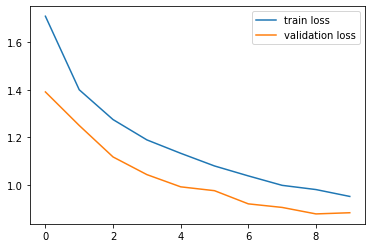

In [13]:
plt.plot(losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()

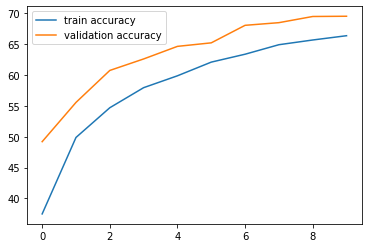

In [14]:
plt.plot(accuracies, label = 'train accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

<Response [200]>


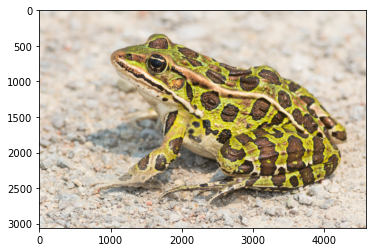

In [15]:
import requests
import PIL
from PIL import Image

url = 'https://static.scientificamerican.com/sciam/cache/file/41DF7DA0-EE58-4259-AA815A390FB37C55_source.jpg'
response = requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)


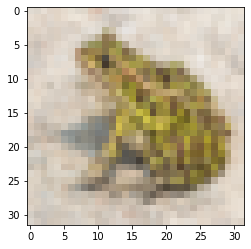

In [16]:
#need to transform image to 32 by 32

img = transform_val(img)
plt.imshow(np.squeeze(img_convert(img))) #now is is like the images we trained

In [17]:
img = img.to(device).unsqueeze(0) # unsqueeze to add additional dimension
outputs = model.forward(img)
_, max_idx = torch.max(outputs, 1)
print(label_classes[max_idx.item()])

frog


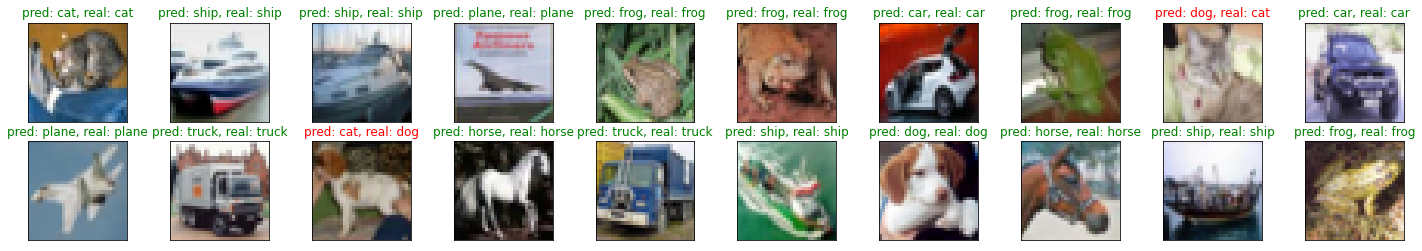

In [18]:
im_iter = iter(val_loader)
images, labels = im_iter.next() # just take one batch and visualize some of these images
images = images.to(device)
labels = labels.to(device)

outputs = model.forward(images)
_, max_idx = torch.max(outputs, 1)


fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(images[i])))
    ax.set_title("pred: {}, real: {}".format(label_classes[max_idx[i].item()], label_classes[labels[i].item()]), color = ("green" if max_idx[i] == labels[i] else "red"))

Ways to improve model accuracy and avoid over fitting:

- add/adjust convolutional layer
- increase learning rate
- add padding
- reduce kernel size
- add data augmentation for training dataset